Для работы использован датасет с https://archive.ics.uci.edu/dataset/172/ozone+level+detection

In [27]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from tensorflow import keras
from keras.layers import LSTM, Dense, Embedding, Concatenate, Activation ,Reshape
from tensorflow.keras.layers import Input, LSTM, concatenate, Dense, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model

In [28]:
def SMAPE(y_true, y_pred):
    numerator = np.abs(y_true-y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred))/2
    res = numerator/denumerator
    res = np.sum(res)
    res *= 100
    res /= len(y_true)
    return res

def Metrix(f_true, f_pred):
    print("RMSE:", np.sqrt(mean_squared_error(f_true, f_pred)))
    print("MAPE:", mean_absolute_percentage_error(f_true, f_pred))
    print("MAE:", mean_absolute_error(f_true, f_pred))
    print("R2: ", r2_score(f_true, f_pred))
    print("SMAPE", SMAPE(f_true, f_pred))

In [29]:
mas  = [
"WSR0","WSR1","WSR2","WSR3","WSR4","WSR5",
"WSR6","WSR7","WSR8","WSR9","WSR10","WSR11",
"WSR12","WSR13","WSR14","WSR15","WSR16","WSR17",
"WSR18","WSR19","WSR20","WSR21","WSR22","WSR23",
"WSR_PK","WSR_AV","T0","T1","T2","T3","T4","T5",
"T6","T7","T8","T9","T10","T11","T12","T13","T14",
"T15","T16","T17","T18","T19","T20","T21","T22","T23",
"T_PK","T_AV","T85","RH85","U85","V85","HT85","T70","RH70",
"U70","V70","HT70","T50","RH50","U50","V50","HT50","KI",
"TT","SLP","SLP_","Precp", "X"]
df = pd.read_csv("./ozone+level+detection/eighthr.data", names=mas) #  onehr
df

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,X
1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,?,?,?,?,?,?,?,?,0.58,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,2.2,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0.0
12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,2.4,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0.0
12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0.0
12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1,1.9,2,...,0.25,7.72,-0.89,5845,-19.6,34.2,10245,-30,0.05,0.0


В данных пропуски заполнены ?, а так же данные считываются как строки

In [30]:
df.replace("?", np.nan, inplace=True)
for i in df.columns:
    print(i)
    df[i] = df[i].astype(float)
    print(df[i].unique())
    print()
df.interpolate(inplace=True)
df.index = pd.to_datetime(df.index)


WSR0
[0.8 2.8 2.9 4.7 2.6 3.1 3.7 2.2 1.  0.9 1.1 1.3 4.2 0.  2.1 2.5 2.7 0.3
 3.4 1.2 2.  0.2 0.7 3.5 1.4 0.1 3.6 1.7 4.4 4.9 1.5 0.4 4.  1.8 3.8 3.2
 6.3 4.8 5.7 5.3 2.3 5.5 1.6 3.  0.5 0.6 1.9 4.1 3.3 2.4 5.8 6.9 nan 4.3
 5.  5.1 6.2 5.9 4.6 5.2 3.9 7.5 4.5 6.  5.6 5.4 6.1 6.7 6.5]

WSR1
[1.8 3.2 2.8 3.8 2.1 3.5 2.9 1.5 0.6 1.7 4.2 1.3 5.1 0.2 2.2 2.3 2.  3.6
 0.7 0.5 0.3 0.4 0.9 3.1 3.3 1.  1.1 3.7 3.  0.1 1.2 4.6 2.5 4.7 2.7 1.4
 1.9 6.8 2.4 4.1 5.5 3.9 0.8 4.8 3.4 5.2 2.6 4.  1.6 0.  5.4 6.7 4.4 nan
 4.3 6.3 4.5 6.1 5.6 5.9 5.  6.5 7.7 5.7 6.2 6.9 5.3 4.9 6.  5.8 6.4]

WSR2
[2.4 3.3 2.6 3.7 1.6 3.8 3.4 1.2 0.5 1.4 3.1 0.3 5.1 0.1 2.2 1.3 1.1 4.1
 2.7 0.8 0.9 2.9 1.7 2.3 2.8 3.  4.6 0.4 1.9 5.5 0.2 3.6 6.4 3.2 1.8 4.
 7.  1.  2.5 0.7 4.2 5.8 3.9 2.1 0.6 2.  4.3 3.5 0.  1.5 5.7 5.  nan 5.3
 6.1 7.1 4.8 5.4 6.9 4.4 4.5 5.2 6.6 5.6 5.9 4.9]

WSR3
[2.1 2.7 3.8 1.4 2.5 5.1 4.2 1.2 0.5 1.5 2.6 1.1 1.7 0.2 2.9 3.2 0.1 0.8
 2.3 3.  3.5 1.9 0.4 2.4 1.  3.1 1.8 5.2 0.3 1.6 6.7 2.8 2.  3.7 6

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2534 entries, 1998-01-01 to 2004-12-31
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WSR0    2534 non-null   float64
 1   WSR1    2534 non-null   float64
 2   WSR2    2534 non-null   float64
 3   WSR3    2534 non-null   float64
 4   WSR4    2534 non-null   float64
 5   WSR5    2534 non-null   float64
 6   WSR6    2534 non-null   float64
 7   WSR7    2534 non-null   float64
 8   WSR8    2534 non-null   float64
 9   WSR9    2534 non-null   float64
 10  WSR10   2534 non-null   float64
 11  WSR11   2534 non-null   float64
 12  WSR12   2534 non-null   float64
 13  WSR13   2534 non-null   float64
 14  WSR14   2534 non-null   float64
 15  WSR15   2534 non-null   float64
 16  WSR16   2534 non-null   float64
 17  WSR17   2534 non-null   float64
 18  WSR18   2534 non-null   float64
 19  WSR19   2534 non-null   float64
 20  WSR20   2534 non-null   float64
 21  WSR21   2534 non-nu

In [32]:
# Скорость ветра
wsr = ["WSR0","WSR1","WSR2","WSR3","WSR4","WSR5",
"WSR6","WSR7","WSR8","WSR9","WSR10","WSR11",
"WSR12","WSR13","WSR14","WSR15","WSR16","WSR17",
"WSR18","WSR19","WSR20","WSR21","WSR22","WSR23",
"WSR_PK","WSR_AV"]
#температура
temp = ["T0","T1","T2","T3","T4","T5",
"T6","T7","T8","T9","T10","T11","T12","T13","T14",
"T15","T16","T17","T18","T19","T20","T21","T22","T23",
"T_PK","T_AV","T85"]
#всё остальное
rest=["RH85","U85","V85","HT85","T70","RH70",
"U70","V70","HT70","T50","RH50","U50","V50","HT50","KI",
"TT","SLP","SLP_","Precp"]

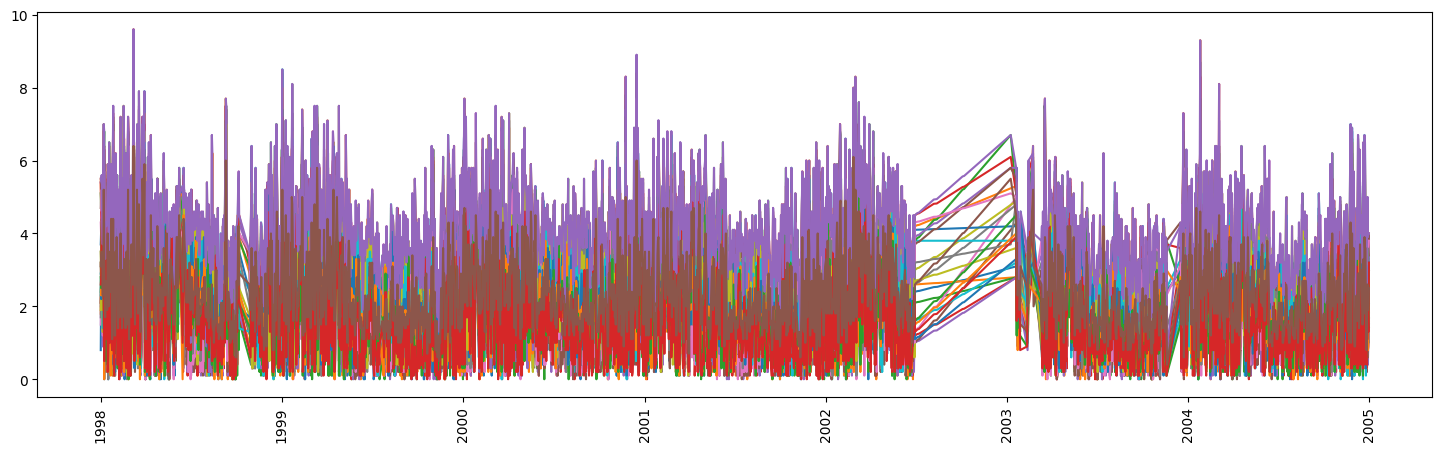

In [33]:
plt.figure(figsize=(18,5))
plt.xticks(rotation=90)
plt.plot(df[wsr])
plt.show()

Видны пропуски ~ с конца 1998 по начало 1999, с середины 2002 по первую четверть 2003 и в конце 2003

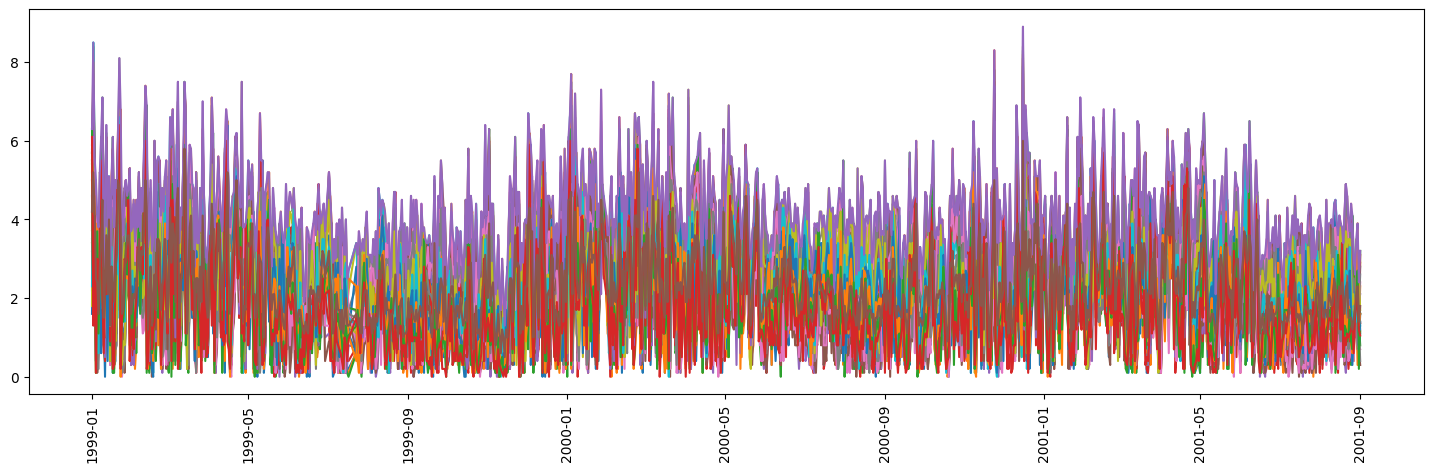

In [34]:
start_date = '1999-01-01'
end_date = '2001-09-01'
subset_df = df.loc[start_date:end_date]

plt.figure(figsize=(18,5))
plt.xticks(rotation=90)
plt.plot(subset_df[wsr])
plt.show()

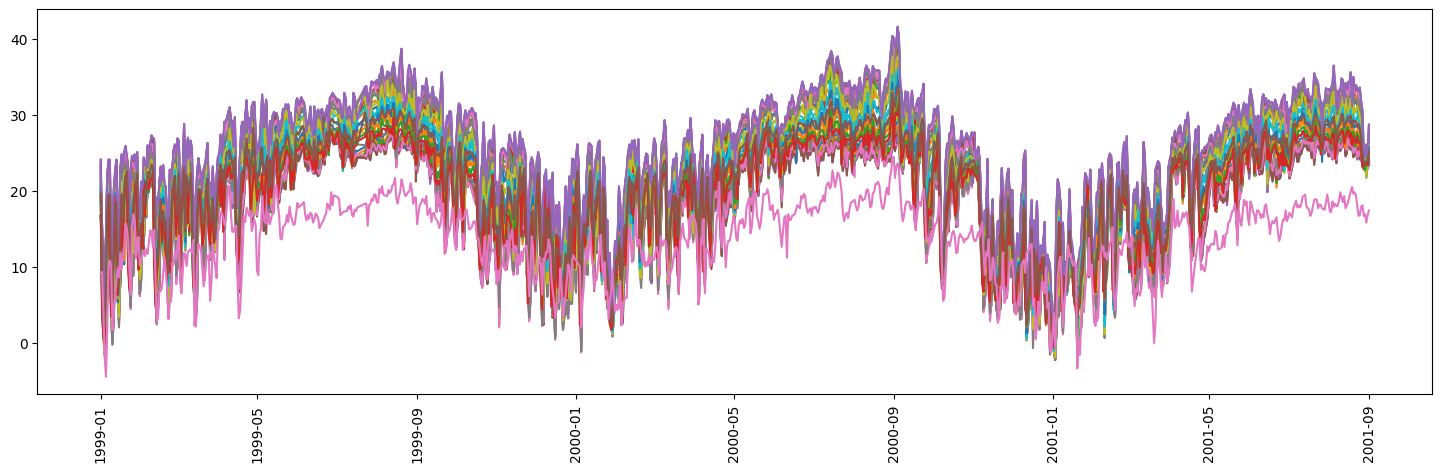

In [35]:
plt.figure(figsize=(18,5))
plt.xticks(rotation=90)
plt.plot(subset_df[temp])
plt.show()

Данные выглядят чистыми

<Axes: >

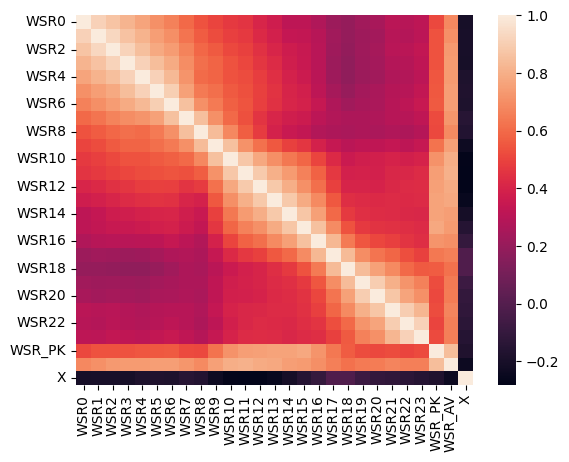

In [36]:
sns.heatmap(subset_df[wsr+['X']].corr())

<Axes: >

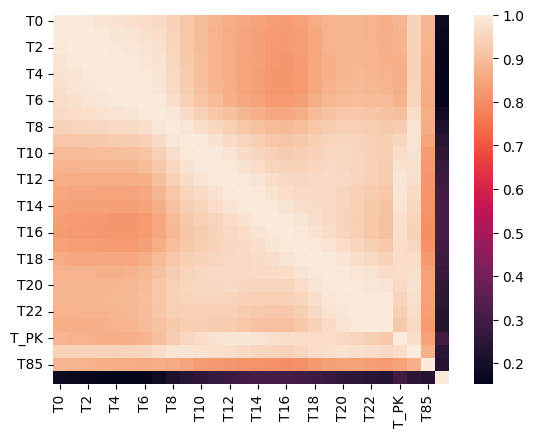

In [37]:
sns.heatmap(subset_df[temp+['X']].corr())

<Axes: >

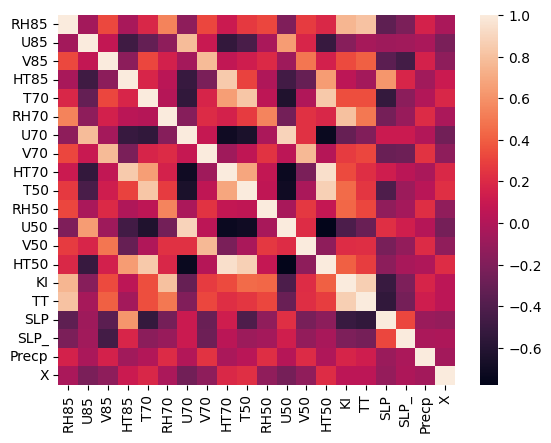

In [38]:
sns.heatmap(subset_df[rest+['X']].corr())

как видно, целевая переменная X плохо коррелирует с остальными показатели

In [39]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR

In [40]:
subset_df.groupby('X')['Precp'].count()

X
0.0    883
1.0     84
Name: Precp, dtype: int64

In [41]:
model = VAR(subset_df)
best_order = model.select_order(maxlags=9)
optimal_order = best_order.selected_orders['aic']
results = model.fit()
train_size = int(0.8 * len(subset_df))
train_data = subset_df[:train_size]
test_data = subset_df[train_size:]
model = VAR(train_data)
results = model.fit(maxlags=optimal_order)
forecasted_values = results.forecast(train_data.values[-optimal_order:], steps=len(test_data))

X_values = []
for i in forecasted_values:
    X_values.append(i[-1])
 
Metrix(test_data['Precp'], forecasted_values[:, subset_df.columns.get_loc('Precp')])

C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE: 2.044832744817762
MAPE: 800952070369378.6
MAE: 0.6850932470151665
R2:  -0.02090279558069197
SMAPE 171.8867684862334


C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


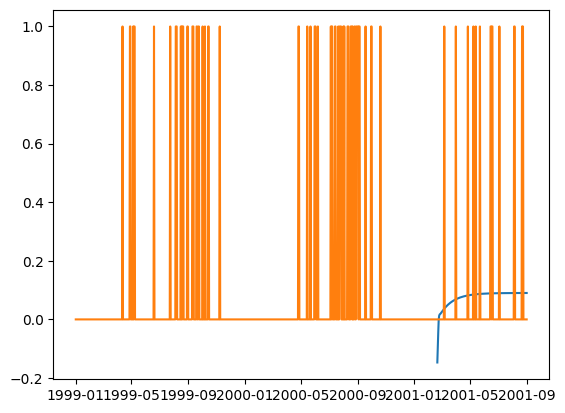

In [42]:
plt.plot(test_data['X'].index, forecasted_values[:, subset_df.columns.get_loc('X')])
plt.plot(subset_df['X'])

Обучение VAR модели не позволяет добиться значительных показателей точности предсказания целевой переменной, поэтому было решено выбрать другую ЦП. Например, атмосферные осадки

In [43]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
import tensorflow as tf
from sklearn.metrics import *

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        epsilon = 1e-7
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, epsilon, 1.0)) + (1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, epsilon, 1.0)))
    return focal_loss_fixed

def set_set(mas, lookback):
    mm = []
    for i in range(len(mas)-lookback):
        mm.append(mas[i:i+lookback])
    return np.array(mm)

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.inter_dim = []
        self.val_inter_dim = []
        self.logits = []
        self.val_logits = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('binary_accuracy'))
        self.val_acc.append(logs.get('val_binary_accuracy'))

        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        clear_output(wait=True)
        try:
            ax1.set_yscale('log')
            ax1.plot(self.x, self.losses, label="loss:" +
                    str(round(logs.get('loss'), 2)))
            ax1.plot(self.x, self.val_losses, label="v_loss:" +
                    str(round(logs.get('val_loss'), 2)))
            ax1.legend()
            print(logs)
            ax2.plot(self.x, self.acc, label="acc:" +
                    str(round(logs.get('binary_accuracy'), 2)))
            ax2.plot(self.x, self.val_acc, label="v_acc:" +
                    str(round(logs.get('val_binary_accuracy'), 2)))
            ax2.legend()
        except:
            pass
        plt.savefig("fig")
        plt.show()


plot = PlotLearning()

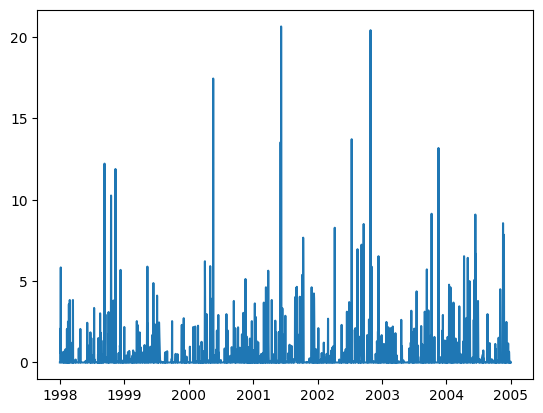

In [44]:
plt.plot(df['Precp'])

In [78]:
arima_model = ARIMA(df['Precp'], order=(3, 4, 4)) #4, 2, 1
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                  Precp   No. Observations:                 2534
Model:                 ARIMA(3, 4, 4)   Log Likelihood               -4581.790
Date:                Wed, 27 Mar 2024   AIC                           9179.580
Time:                        23:49:08   BIC                           9226.268
Sample:                             0   HQIC                          9196.520
                               - 2534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5816      0.007   -231.313      0.000      -1.595      -1.568
ar.L2         -0.8999      0.010    -90.223      0.000      -0.919      -0.880
ar.L3         -0.3173      0.006    -55.730      0.0

In [84]:
X = df['Precp'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
train_c, test_c = train.copy(), test.copy() 
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(4,5,5),enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leous\AppData\Local

In [85]:
print('Обучающие данные',len(train))
print('Тренировочные данные',len(test))

Обучающие данные 2027
Тренировочные данные 507


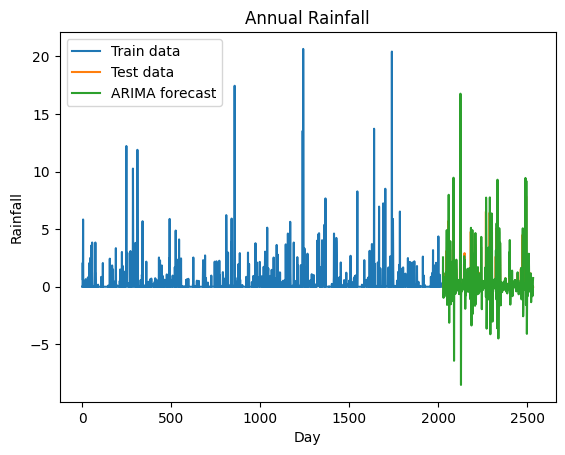

In [86]:
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARIMA forecast')
plt.legend()#, fontsize="20"
plt.title('Annual Rainfall')
plt.ylabel('Rainfall')#, fontsize="20"
plt.xlabel('Day')#, fontsize="20"
plt.show()

In [87]:
Metrix(test[:dur], arma_predictions)

RMSE: 2.210632608780471
MAPE: 2479735281266924.5
MAE: 1.1915577018434378
R2:  -1.623094690652393
SMAPE 184.42504782926588
